<a href="https://colab.research.google.com/github/EthanJTucker/DTSA_5511_HW/blob/main/Week3_CNN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DTSA-5511: Week 3 Mini- Project
## Cancer Detection with CNN
## Ethan Tucker
### 8/7/2022


## Step 1: Brief description of the problem and data

In this project I will make use of a convolutional nueral network (CNN) in order to detect metatstatic cancer in cells. The data used will be from a a (Kaggle Competition)[https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview]. The data are RGB images, with corresponding labels supplied for the training data. I will run my model on the test data to generate models and validate the test accuracy using Kaggle's submission feature. 
The data are split into two binary exlusive classes. The images are of cells that either do or do not have cancer. In total, there are 220,025 training cases. I chose to use 80% for training, and 20% for validation in accordance with the rule of thumb. The  According to the Kaggle listing, the training data, test data, and labels combined consist of a ~7.75 GB file. There will be some duplication of data in the effort of unzipping the file during download, so if your machine experiences lag after loading, a good intermediate step would be to delete the ZIP file after unzipping.

The individual image files are all .tif files of shape (96, 96, 3). According to the Kaggle listing, the training label is assigned as positive if at least one pixel in the center (32, 32) of an image contains tumorous tissue. The rest of the image is provided to enable CNN with padding schemes / convolution stride that eats away at the exterior of the image. 

The test dataset consists of unlabeled .tif images. The goal of this project is to predict the labels of those test images with the CNN I will build.

# Step 2: Data Loading, Cleaning, and EDA 

First we'll load the necessary libraries. Please ensure that you have these installed on your environment before running this notebook.


In [2]:
# Load libraries for project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import cv2 # For EDA
from PIL import Image
import sys

# Data download

Now we will go about loading the data from the [Kaggle competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) into the colab. Please ensure that your current working directory contains the requisite data files for this project.  
Citation: https://towardsdatascience.com/7-ways-to-load-external-data-into-google-colab-7ba73e7d5fc7

In [3]:
from google.colab import files
uploaded = files.upload() # Please upload your kaggle.json file

Saving kaggle.json to kaggle.json


In [ ]:
!pwd

/content


In [4]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
"chmod 600 /content/kaggle.json"

'chmod 600 /content/kaggle.json'

In [5]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [00:27<00:00, 234MB/s]
100% 6.31G/6.31G [00:27<00:00, 246MB/s]


In [5]:
os.listdir(".") #The data have been successfully downloaded. Now we need to unzip.

['.config',
 'histopathologic-cancer-detection.zip',
 'kaggle.json',
 'sample_data']

In [6]:
!unzip "./histopathologic-cancer-detection.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

#### Commentary

Now that the data are downloaded into the colab, we can go about loading them into tf.data.Dataset object. We will use the tf.keras.image_dataset_from_directory function to load in the data simply and efficiently. Unfortunately the training labels are stored in a seperate .csv file, so we will need to do some cleaning. Along with the label is a column denoting the file name of the corresponding training image. My cleaning approach was to sort the .csv by file name, pull the id's, sort the training data in an identical manner, then place all data in subdirectories corresponding to the datum label. This has the extreme benefit of allowing lazy loading for the keras.utils.image_dataset_from_directory method, built for CNN.

Citation:

 https://keras.io/api/data_loading/image/ 

In [7]:
#Display files in current working directory. Should include test, train, and train_labels
os.listdir("./")

['.config',
 'kaggle.json',
 'sample_submission.csv',
 'test',
 'train',
 'train_labels.csv',
 'histopathologic-cancer-detection.zip',
 'sample_data']

#### Cleaning Note:

It turns out that all the image files provided in the Kaggle competition have the .tif extension, which Keras dislikes. We will need to convert these to .png in order for Keras to succeed in creating our Data object. I'll write a custom function to do this in a cell chunk below.

Citation: 

https://www.code-learner.com/how-to-convert-image-format-using-pillow-in-python/

In [8]:
def convertToPNG(newDir, oldDir, fileName):
  """
  This function converts a .tif image file from oldDir to a .png and saves it to
  newDir. 
  Input: string filePath
  Output: None
  """
  targetPath = newDir + fileName[:-4] + ".png"
  this_img = Image.open(oldDir + fileName)
  this_img.save(targetPath)
  this_img.close()

In [9]:
# Make necessary containers for converted training images
## with subdirectories for binary classification
dir0train = "./pngContainer/pngTrain/0/"
dir1train = "./pngContainer/pngTrain/1/"
os.makedirs(dir0train)
os.makedirs(dir1train)

#Read in and sort training labels alphanumerically. The sorting is identical
## to the sorting we will perform on the images (they have the same names).
train_labs_df = pd.read_csv("./train_labels.csv")
training_labels = list(train_labs_df.sort_values(by = "id", axis = 0)["label"])

# Convert all .tif files in "./train/" to .png 's . This will take about 10
## minutes total.
train_dir = "./train/"
train_imgs = os.listdir(train_dir)
train_imgs.sort()

#Quick sanity check
assert len(train_imgs) == len(training_labels)

#Populate subdirectories. This will take a while (for me ~ 10 minutes). Grab a
## snack. If there is a better way to do this I'm all ears.
for i in range(len(train_imgs)):
  if training_labels[i] == 0:
    convertToPNG(dir0train, train_dir, train_imgs[i])
  else:
    assert training_labels[i] == 1
    convertToPNG(dir1train, train_dir, train_imgs[i])

In [10]:
#Check that files got properly put in "./pngContainer/pngTrain" and converted to
## .png
os.remove("./histopathologic-cancer-detection.zip")
os.listdir("./pngContainer/pngTrain")

['0', '1']

In [11]:
# Call image_dataset_from_directory to build keras Data object
train_data = tf.keras.utils.image_dataset_from_directory(
    directory = "/content/pngContainer/pngTrain",
    labels = "inferred",
    label_mode = "binary",
    color_mode = "rgb",
    image_size = (96, 96),
    seed = 42,
    batch_size = 32
)

Found 220025 files belonging to 2 classes.


In [12]:
#Confirm that training data was propertly loaded
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

### Even More Exploratory Data Analysis

I will first show an example photo from the training data, along with its type and shape. 

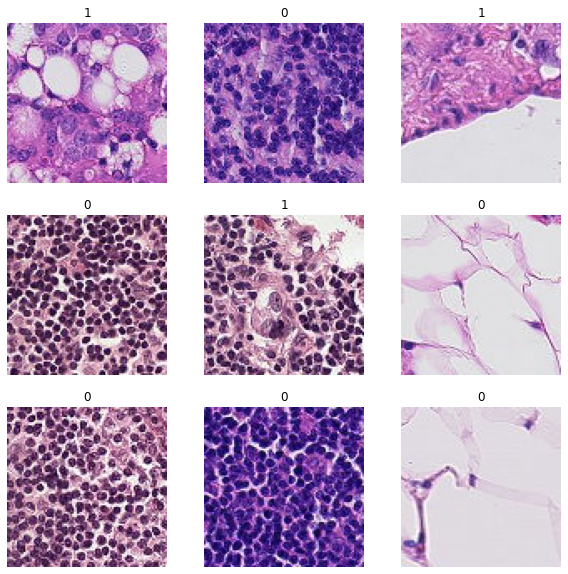

In [14]:
# More Example Images
#Citation https://keras.io/examples/vision/image_classification_from_scratch/

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

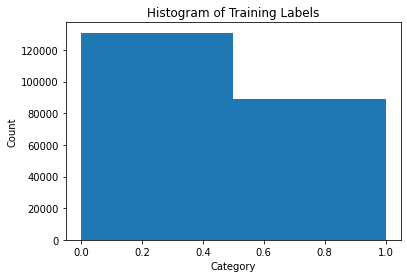

In [ ]:
# Make Histogram of Training Labels
plt.hist(training_labels, bins = 2)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Histogram of Training Labels")
plt.show()

I would like to do an EDA that consists of examining the brightness per pixel (max, min, mean) over each of the three RGB channels, but doing so would involve re-loading all of the training data using cv2, which seems like a drastic waste of memory. If you would like to see an example where I do such an EDA, please visit [my GitHub](https://github.com/EthanJTucker/DTSA_5510_HW/blob/main/Final_Project/DTSA_5510_Final_Project.ipynb).

# Step 3: Model Architecture and Construction

I will try a couple different architectures, because CNN architecture itself is a hyperparameter that needs optimization. Keras provides a wonderful API to build simple CNN's in. In particular, the Sequential API is built for single input single output models. We are inputting single images, and want to output a single label, so the Sequential API works perfect. 

We learned in class that the basic effective architecture for a CNN looks like [convolve -> convolve -> maxpool]$_n$, and then fed into a dense ANN for classification. I will use $n = 3$ for my project, because as $n$ increases the CNN develops the ability to "see" more macroscopic trends in the data, which may indicate the present of cancerous tissue. By preventing too many layers, we can try and prevent overfitting.

We learned that either relu or PreLu is the best choice of activation function for hidden layers. The Keras Sequential API doesn't have a built in PreLu, and I fear that any that I implement will be algorthmically inefficient in Python, so I won't worry about optimizing the interem activation functions. We will use (3x3) filters as suggested. I will try both the Adam and RMSProp optimizers, and various values of learning rate between (0.0001, 0.001). I will also use a learning_rate scheduler to minimize variance towards the end of training. I will try Dropout layers in various locations. I will use binary cross entropy as my loss function, because it is the most appropriate for logit outputs from a sigmoid output activation.

All of my hyperparameter tuning will be done manually. The fitting will take a while, but will return the optimal choice of architecture and hyperparameters by validation accuracy.

Citations:

https://www.tutorialspoint.com/keras/keras_convolution_neural_network.htm


https://keras.io/guides/sequential_model/

https://keras.io/api/models/model_training_apis/

In [12]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten

def buildaModel(eta, dropout1, dropout2, optimizer):
  """
  This function builds a model according to the hyperparamaters passed. The documentation for keras-tuner is quite poor, and there are many bugs.
  I will just make my own grid searcher.

  Inputs:
    float eta, learning rate
    Boolean dropout1, whether to include dropout layer after first c-c-m
    Boolean dropout2, whether to include dropout layer after second c-c-m
    string optimizer, either "Adam" or "RMSprop"
  
  Output: Keras sequential model object
  """
  batch_input_shape = (32, 96, 96, 3) # Mini-batches are of size 32. Images are of shape (96, 96, 3)
  model = tf.keras.Sequential()
  model.add(BatchNormalization(axis = -1))
  #CNN [c, c, m] Layers
  model.add(Conv2D(32,
                   kernel_size = 3,
                   padding="same",
                   activation = "relu",
                   batch_input_shape = batch_input_shape))
  model.add(Conv2D(32, kernel_size = 3, activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(BatchNormalization(axis = -1)) #Normalize to prevent overfitting

  model.add(Conv2D(64, kernel_size = 3, activation = "relu"))
  model.add(Conv2D(64, kernel_size = 3, activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  #Decide whether or not to use a Dropout between [c, c, m] instances
  model.add(BatchNormalization(axis = -1)) #Normalize to prevent overfitting

  model.add(Conv2D(128, kernel_size = 3, activation = "relu"))
  model.add(Conv2D(128, kernel_size = 3, activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  #Decide whether or not to use a Dropout between [c, c, m] instances
  model.add(BatchNormalization(axis = -1)) #Normalize to prevent overfitting

  #Now send the model into an ANN for binary classification
  model.add(Flatten())
  if dropout1:
    model.add(Dropout(0.25))
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(128, activation = "relu"))
  if dropout2:
    model.add(Dropout(0.25))
  model.add(Dense(32, activation = "relu"))
  model.add(Dense(1, activation = "sigmoid")) #Output layer

  #Make a learning rate schedule to prevent variance at the end of training
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate = eta,
      decay_steps = 10000,
      decay_rate=0.9
      )
  
  #Compile the model
  if optimizer == "Adam":
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
      loss = "binary_crossentropy",
      metrics=["accuracy"]
    )
  else:
    assert optimizer == "RMSprop"
    model.compile(
      optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
      loss = "binary_crossentropy",
      metrics = ["accuracy"]
    )
  return(model)

In [13]:
#Trial model before gridsearch
myModel = buildaModel(eta = 0.001, dropout1 = True, dropout2 = True, optimizer = "Adam")
callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 10, mode = "min")]
history = myModel.fit(train_data,
                      epochs = 99,
                      steps_per_epoch = len(train_data)/100,
                      callbacks = callbacks_list)

print(myModel.summary())

Epoch 1/99
68/68 [==============================] - 19s 61ms/step - loss: 0.6519 - accuracy: 0.7047
Epoch 2/99
68/68 [==============================] - 4s 61ms/step - loss: 0.5592 - accuracy: 0.7591
Epoch 3/99
68/68 [==============================] - 4s 61ms/step - loss: 0.4936 - accuracy: 0.7754
Epoch 4/99
68/68 [==============================] - 4s 61ms/step - loss: 0.4767 - accuracy: 0.7853
Epoch 5/99
68/68 [==============================] - 4s 61ms/step - loss: 0.4668 - accuracy: 0.7962
Epoch 6/99
68/68 [==============================] - 4s 58ms/step - loss: 0.4586 - accuracy: 0.8007
Epoch 7/99
68/68 [==============================] - 4s 60ms/step - loss: 0.4594 - accuracy: 0.8034
Epoch 8/99
68/68 [==============================] - 4s 62ms/step - loss: 0.4389 - accuracy: 0.8120
Epoch 9/99
68/68 [==============================] - 4s 60ms/step - loss: 0.4213 - accuracy: 0.8116
Epoch 10/99
68/68 [==============================] - 4s 58ms/step - loss: 0.4122 - accuracy: 0.8225
Epoch 11

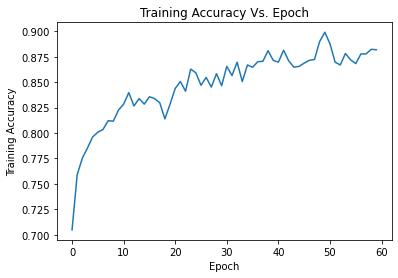

In [14]:
# Make a nice visualization of our test model: Training Accuracy Vs. Epoch
testAccs = history.history["accuracy"]
epochs = [i for i in range(len(testAccs))]
plt.plot(epochs, testAccs)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Vs. Epoch")
plt.show()

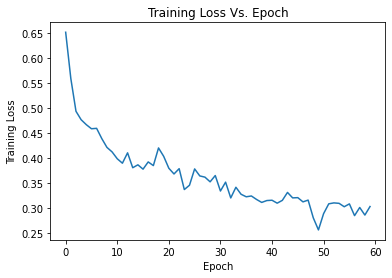

In [15]:
# Make another nice visualization: Loss Vs. Epoch
testLosses = history.history["loss"]
plt.plot(epochs, testLosses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Vs. Epoch")
plt.show()

### Success!

Now that we have confirmed that the model construction function works, we can go about doing our HP optimization. To reiterate, we will choose various initial learning rates and dropout layer inclusions to differentiate our models. The values of $\eta$ that I will initially scan are $\{0.0001, 0.0005, 0.001, 0.005, 0.01\}$. After running these models, I will try some ad hoc values to get try and get the validation accuracy up a bit more. After this I will experiment with dropout layers. I want at least one dropout layers, so I will try permutations with at least one 'True' values. Finally, we will also try changing the optimizer.

This next cell execution will take a while - go grab a snack (or just don't execute it because it is pre-populated in the .ipynb). The total training time for the test model was ~ 3.5 minutes, so over 30 options we would expect 105 minutes of training.

In [22]:
#Perform HP optimization
import itertools
startTime = time.time()

eta_to_try = [0.0001, 0.0005, 0.001, 0.005, 0.01]
dropouts_to_try = [(True, True)]
optimizers_to_try = ["Adam", "RMSprop"]

hpPermutations = list(itertools.product(*[eta_to_try, dropouts_to_try, optimizers_to_try]))
current_best_model = (None, 0)
current_best_history = None

model_accuracies = list()
for hpList in hpPermutations:
  print("Now trying hyperparams:", hpList)
  this_model = buildaModel(eta = hpList[0],
                           dropout1 = hpList[1][0],
                           dropout2 = hpList[1][1],
                           optimizer = hpList[2]
                           )
  this_history = this_model.fit(train_data,
                                epochs = 99,
                                steps_per_epoch = len(train_data)/100,
                                callbacks = callbacks_list
                                )
  if this_history.history["accuracy"][-1] > current_best_model[1]:
    current_best_model = (this_model, this_history.history["accuracy"][-1])
    current_best_history = this_history.history

endTime = time.time()
print("Total HP optimization time:", round((endTime - startTime)/60, 3), "minutes")

Now trying hyperparams: (0.0001, (True, True), 'Adam')
Epoch 1/99
68/68 [==============================] - 3s 32ms/step - loss: 0.5324 - accuracy: 0.7455
Epoch 2/99
68/68 [==============================] - 2s 31ms/step - loss: 0.5216 - accuracy: 0.7636
Epoch 3/99
68/68 [==============================] - 3s 40ms/step - loss: 0.4829 - accuracy: 0.7803
Epoch 4/99
68/68 [==============================] - 3s 39ms/step - loss: 0.4773 - accuracy: 0.7822
Epoch 5/99
68/68 [==============================] - 2s 30ms/step - loss: 0.4778 - accuracy: 0.7812
Epoch 6/99
68/68 [==============================] - 2s 31ms/step - loss: 0.4719 - accuracy: 0.7808
Epoch 7/99
68/68 [==============================] - 2s 31ms/step - loss: 0.4644 - accuracy: 0.7962
Epoch 8/99
68/68 [==============================] - 2s 31ms/step - loss: 0.4612 - accuracy: 0.7885
Epoch 9/99
68/68 [==============================] - 2s 31ms/step - loss: 0.4442 - accuracy: 0.8021
Epoch 10/99
68/68 [==============================] - 2

## Results and Analysis

The model is trained! We performed a grid search over a few hyperparameters, namely various selections of learning rate chosen logarithmically on the set [0.0001, 0.01], and where to use dropout layers.

The metric we optimized against was validation accuracy. I expect the test data to have accuracy approximately equal to the best validation accuracy, because we didn't train the CNN on either set. I'll make visualizations of validation_accuracy vs. epoch, and training loss vs. epoch. I think some great visualizations I'll do for my final will be validation accuracy vs. $\eta$, and execution time vs. validation accuracy. Unfortunately for this project I couldn't get the model.fit() method to accept validation_data, but I found a nice tutorial online where I think I can replicate the results. That's for another day.

After these visualizations I will create label predictions for the test set, then send them to Kaggle for the test accuracy.

In [ ]:
# Make Epochs Vs. Training Accuracy for beest model
accs = current_best_history["accuracy"]
epochs = [i for i in len(range(accs))]

plt.plot(epochs, accs)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Vs. Epoch for Best Model: HPs (Fill in later)")
plt.show()

In [ ]:
# Make Epochs Vs. Training Loss for best model
loss = current_best_history["loss"]

plt.plot(epochs, loss)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Vs. Epoch for Best Model: HPs (Fill in Later)")
plt.show()

In [ ]:
# Make necessary containers for converted test images. This section will be
## basically a mirror of the .tif -> .png conversion done on the training data.
dirTestTarget = "./pngContainer/pngTest/imgs/"
#Note we require .../imgs/ so that there exists a subdirectory for keras to find
os.makedirs(dirTestTarget)
test_dir = "./test/"
test_imgs = os.listdir(test_dir)
test_imgs.sort()

for img in test_imgs:
  convertToPNG(dirTestTarget, test_dir, img)

# Make test_data as BatchDataset
test_data = tf.keras.utils.image_dataset_from_directory(
    directory = "/content/pngContainer/pngTest",
    labels = None,
    label_mode = "binary",
    color_mode = "rgb",
    image_size = (96, 96),
    batch_size = 32
)